# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics
Jessica Hin  
008515095  
May 20th, 2024  

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


In [1]:
# installing the libraries I need
#!pip install emoji
#!pip install collections
#!pip install nltk
#!pip install string

In [2]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "C:/Users/jessh/Documents/ADS509/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder =  "lyrics/"

In [4]:
def descriptive_stats(tokens, num_tokens = 5 , verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    flat_tokens = [token for token in tokens if not isinstance(token,float)]
    #flat_tokens = [token for sublist in tokens if isinstance(sublist, list) for token in sublist if not isinstance(token, float)]
    num_tokens = len(flat_tokens) # number of tokens
    num_unique_tokens = len(set(flat_tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens  # lexical diversity
    num_characters = sum(len(token) for token in flat_tokens) # number of characters
    most_common_tokens = Counter(flat_tokens).most_common(num_tokens)[0:5] # most common tokens
   
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    print(f"The five most common tokens are {most_common_tokens} in the data.")      
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
The five most common tokens are [('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)] in the data.
The five most common tokens are [('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)] in the data.
The five most common tokens are [('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)] in the data.
The five most common tokens are [('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)] in the data.


Q: Why is it beneficial to use assertion statements in your code? 

A: It is beneficial to use assertion statements to test, debug, and detect errors. In this case, it is used to check if your user defined function works as expected. Based on the the text above, the assertions statements check if the number of tokens, number of unique tokens, characters, and lexical diversity are correct. If it does, then there should be a "AssertionError" flag.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




### Reading in Lyrics

In [6]:
# user defined function for removing the www.azlyrics.com portion of the filenames
def edit_filename(link) :
    
    if not link :
        return None

    # drop the http or https and the html
    name = link
    name = re.sub(r'^www_azlyrics_com_', '', name)
    
    return(name)

This next cell of code was just renaming the files within each artist's folder. The for loop was ran twice for each artist.

In [7]:
# renaming all the files in each artist folders to remove the www_azlyrics_com_ portion in the filename
dualipa_folder_path = data_location + lyrics_folder + "dualipa"
hozier_folder_path = data_location + lyrics_folder + "hozier"

# List all files in the folder
files = os.listdir(hozier_folder_path)

# Iterate through each file and rename them
for filename in files:
    # Construct the full old and new file paths
    old_filepath = os.path.join(hozier_folder_path, filename)
    new_filename = old_filepath.replace("www_azlyrics_com_", "") 
    new_filepath = os.path.join(hozier_folder_path, new_filename)
    
    try:
        # Rename the file
        os.rename(old_filepath, new_filepath)
    except Exception as e:
        print(f"Failed to rename '{filename}': {e}")

print("Files renamed successfully!")

Files renamed successfully!


We have to get to the folder of each artist and then pull the text files and store them into a dataframe. The folder path that contained both artist was defined first, then within the first for loop, they got the path to each artist and their corresponding lyric files. The result is a dataframe with "Filename" as one column and another column "File Content" that contains the whole text file content. 

In [8]:
# getting the path to the lyrics folder
folder_path = data_location + lyrics_folder

# List to store all file paths
all_file_paths = []

# go through all directories and subdirectories
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        all_file_paths.append(file_path)
        
# read the contents of each file and store them along with the filename using the folder_paths variable
file_data = []
for file_path in all_file_paths:
    with open(file_path, 'r') as file:
        content = file.read()
        filename = os.path.relpath(file_path, folder_path) # Get the relative path as filename
        filename = os.path.basename(filename) # only getting the filename of whatever we pulled
        file_data.append((filename, content))

# create a dataframe with columns 'Filename' and 'File Content'
df = pd.DataFrame(file_data, columns=['Filename', 'File Content'])

# Display the dataframe
df.head(5)

,Filename,File Content
0,dualipa_badtogether.txt,"""Bad Together"" lyrics\n\nDua Lipa Lyrics\n\n\n..."
1,dualipa_begging.txt,"""Begging"" lyrics\n\nDua Lipa Lyrics\n\n\n\n\n""..."
2,dualipa_betheone.txt,"""Be The One"" lyrics\n\nDua Lipa Lyrics\n\n\n\n..."
3,dualipa_blowyourmindmwah.txt,"""Blow Your Mind (Mwah)"" lyrics\n\nDua Lipa Lyr..."
4,dualipa_dreams.txt,"""Dreams"" lyrics\n\nDua Lipa Lyrics\n\n\n\n\n""D..."


### Reading in Twitter data

Reading in the twitter files is easier. Since we only need the cher_followers_data and robynkonichiwa_followers_data, we're going to read in both and append it to each other to create one dataframe.

In [9]:
# change working directory
os.chdir(data_location+twitter_folder)

# define filepath for robyn
robyn_filepath = "robynkonichiwa_followers_data.txt"

# Read in the text file as a DataFrame
robyn_df = pd.read_csv(robyn_filepath, delimiter='\t') 
robyn_df.head(5)

,screen_name,name,id,location,followers_count,friends_count,description
0,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,I love chill •Facebook / Instagram / SoundClou...
1,songsfornikola,johnny,1502717352575651840,NaN,6,318,"books, movies, music, nature & TV shows. OG Sw..."
2,thibaud_lola,Thibaud Lola,1502407708246478852,NaN,3,69,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...
3,KyleSew2112,Kyle S 🌹🇬🇧🇺🇦,3423966821,South East London,1258,3444,This Twitter profile is full of sarcasm and ra...
4,MusiFlo,MusiFlo,3324069364,Canada,470,1706,Flora Youssef - Blogger & Founder Posting revi...


The cher data file gave me more trouble with a row reading as 12 columns instead of 7, so i had to find a way around that.

In [10]:
# define filepath for cher
cher_filepath = "cher_followers_data.txt"

# define column names
columns = ["screen_name", "name", "id", "location", "followers_count", "friends_count", "description"]

# Initialize an empty list to store data
data = []

# Open the text file and read line by line
with open(cher_filepath, 'r', encoding = 'utf-8') as file:
    for line in file:
        # Split the line by tab delimiter
        fields = line.strip().split('\t')
        # If the line has expected number of fields
        if len(fields) == len(columns):
            data.append(fields)

# the list will be changed to a dataframe
cher_df = pd.DataFrame(data, columns=columns)

# dropping the first row
cher_df = cher_df.iloc[1:]
cher_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
cher_df.head(5)

,screen_name,name,id,location,followers_count,friends_count,description
0,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
1,anju79990584,anju,1496463006451974150,,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
2,gallionjenna,J,3366479914,,752,556,csu
3,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...
4,Rodhandyjj,Art Vandalay 🇺🇦🇺🇦🇺🇦,1386454132022824962,"Maine, USA",104,159,I’m unemployed and live with my parents. MOOPS!


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [11]:
sw = set(stopwords.words("english")) 
punctuation = set(punctuation) # speeds up comparison

In [12]:
# create your clean twitter data here
# create a function to clean data
def clean_data(text):
    if isinstance(text, str):
        new_text = ''.join(char for char in text if char not in punctuation) # getting rid of punctuation
        
        # fold to lowercase and split on whitespace
        tokens = new_text.lower().split()
        
        # remove stopwords
        cleaned_tokens = [token for token in tokens if token not in sw]
        
        return cleaned_tokens
    else:
        return(text)


# apply to each cell of the dataframe for cher
new_cher_df = cher_df['description'].apply(clean_data)
new_cher_df.head(5)

0        [𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]
1        [163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]
2                                                [csu]
3    [writer, washinformer, spelmancollege, alumna,...
4              [i’m, unemployed, live, parents, moops]
Name: description, dtype: object

In [13]:
# apply to each cell of the dataframe for robyn
new_robyn_df = robyn_df['description'].apply(clean_data)
new_robyn_df.head(5)

0    [love, chill, •facebook, instagram, soundcloud...
1    [books, movies, music, nature, tv, shows, og, ...
2    [amauteur, en, herbe, 🌱, juriste, en, paille, ...
3    [twitter, profile, full, sarcasm, rants, occas...
4    [flora, youssef, blogger, founder, posting, re...
Name: description, dtype: object

In [14]:
# create your clean lyrics data here
# creating a new df
lyrics_df = df

# splitting based on artist for lyrics
dualipa_lyrics_df = df[df['Filename'].str.contains('dualipa', case = False)].reset_index()
hozier_lyrics_df = df[df['Filename'].str.contains('hozier', case = False)].reset_index()

# cleaning the data
new_dualipa_lyrics = dualipa_lyrics_df['File Content'].apply(clean_data)
new_hozier_lyrics = hozier_lyrics_df['File Content'].apply(clean_data)

In [15]:
new_dualipa_lyrics.head(5)

0    [bad, together, lyrics, dua, lipa, lyrics, bad...
1    [begging, lyrics, dua, lipa, lyrics, begging, ...
2    [one, lyrics, dua, lipa, lyrics, one, see, moo...
3    [blow, mind, mwah, lyrics, dua, lipa, lyrics, ...
4    [dreams, lyrics, dua, lipa, lyrics, dreams, la...
Name: File Content, dtype: object

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

I had to rewrite the descriptive_stats function in order to read in the nested list of words.

In [16]:
def new_descriptive_stats(tokens, num_tokens = 5 , verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    flat_tokens = [token for sublist in tokens if isinstance(sublist, list) for token in sublist if not isinstance(token, float)]
    total_tokens = len(flat_tokens)  # total number of tokens
    num_tokens = len(flat_tokens) # number of tokens
    num_unique_tokens = len(set(flat_tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens  # lexical diversity
    num_characters = sum(len(token) for token in flat_tokens) # number of characters
    most_common_tokens = Counter(flat_tokens).most_common(num_tokens)[0:5] # most common tokens
   
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    print(f"The five most common tokens are {most_common_tokens} in the data.")      
    
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [17]:
# calls to descriptive_stats here

new_descriptive_stats(new_dualipa_lyrics)
new_descriptive_stats(new_hozier_lyrics)
new_descriptive_stats(new_cher_df)
new_descriptive_stats(new_robyn_df)

There are 3659 tokens in the data.
There are 644 unique tokens in the data.
There are 16863 characters in the data.
The lexical diversity is 0.176 in the data.
The five most common tokens are [('dont', 99), ('love', 88), ('im', 81), ('know', 79), ('like', 61)] in the data.
There are 2957 tokens in the data.
There are 942 unique tokens in the data.
There are 14867 characters in the data.
The lexical diversity is 0.319 in the data.
The five most common tokens are [('power', 51), ('love', 48), ('little', 41), ('lyrics', 40), ('oh', 33)] in the data.
There are 15670504 tokens in the data.
There are 1517718 unique tokens in the data.
There are 92951718 characters in the data.
The lexical diversity is 0.097 in the data.
The five most common tokens are [('love', 214576), ('im', 139098), ('life', 122980), ('music', 88177), ('de', 72974)] in the data.
There are 1538163 tokens in the data.
There are 271325 unique tokens in the data.
There are 9397180 characters in the data.
The lexical diversity

[1538163, 271325, 0.1763954795428053, 9397180]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: The stopwords would probably dominate the "top 5 words" list. This would also mean we wouldn't have gotten meaningful insights on the actual top lyrics since stop words aren't necessarily content words.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: For context, the first 2 outputs are for the lyrics and the last two outputs are for the twitter posts. I thought the lyrics would contain less lexical diversity than the twitter posts. However, it seems like the twitter posts have less diversity than the lyrics. That's surprising since there are more people contributing to twitter posts than the lyrics, as there is only one artist linked to them.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [18]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [19]:
# gotta make everything a str, not list
def list_to_str(cell):
    if isinstance(cell, float):
        return ''
    cell = [item for item in cell if not isinstance(item, float)] # filtering out float values
    return ''.join(map(str,cell))

# create a function to extract emojis from text
def extract_emojis(text):
    demojized_text = emoji.demojize(text)
    return re.findall(r':[a-zA-Z_0-9]+:', demojized_text) # matching on regular expression to get the entirety of the emoji out


In [20]:
# cher tweets
# changing the pandas dataframe variable to a str
cher_emos = new_cher_df.apply(list_to_str)
new_cher_emos = cher_emos.apply(extract_emojis)

# flatten the list of emojis
emojis_flat = [emoji for sublist in new_cher_emos for emoji in sublist]

# count the emojis
emoji_counts = Counter(emojis_flat)

# find the ten most common emojis
top_cher_emojis = dict(emoji_counts.most_common(10))

print(top_cher_emojis)


{':red_heart:': 76843, ':heart_suit:': 33883, ':rainbow_flag:': 30347, ':sparkles:': 29250, ':blue_heart:': 21143, ':water_wave:': 20083, ':rainbow:': 16699, ':purple_heart:': 16388, ':United_States:': 14539, ':victory_hand:': 11797}


In [21]:
# robyn tweets
# changing the pandas dataframe variable to a str
robyn_emos = new_robyn_df.apply(list_to_str)
new_robyn_emos = robyn_emos.apply(extract_emojis)

# flatten the list of emojis
emojis_flat = [emoji for sublist in new_robyn_emos for emoji in sublist]

# count the emojis
emoji_counts = Counter(emojis_flat)

# find the ten most common emojis
top_robyn_emojis = dict(emoji_counts.most_common(10))

print(top_robyn_emojis)

{':red_heart:': 4645, ':rainbow_flag:': 3253, ':heart_suit:': 3113, ':sparkles:': 2224, ':rainbow:': 1408, ':blue_heart:': 806, ':victory_hand:': 791, ':purple_heart:': 735, ':musical_notes:': 698, ':black_heart:': 611}


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [22]:
# create a function to semi-clean data
# the function before removed all punctuations, including hashtags
# we want them back in 

# clean the raw data again except for punctuation
def semi_clean_data(text):
    if isinstance(text, str):
        
        # fold to lowercase and split on whitespace
        tokens = text.lower().split()
        
        # remove stopwords
        cleaned_tokens = [token for token in tokens if token not in sw]
        
        return cleaned_tokens
    else:
        return(text)
    
# find the all the hashtags
def common_hashtags(texts):
    
    hashtags_count = Counter()
    
    for text in texts:
        hashtags = re.findall(r'#\w+\s*\w*', text)
        if hashtags:
            hashtags_count.update(hashtags)
    
    return hashtags_count

# count the hashtags that are the same in the counter

def count_hashtags(hashtags_counters):
    hashtag_counts = defaultdict(int)
    for counter in hashtags_counters:
        for hashtag, count in counter.items():
            hashtag_counts[hashtag] += count
    return dict(hashtag_counts)

# gotta change the panda series to strings

def list_to_str(cell):
    if isinstance(cell, float):
        return ''
    cell = [item for item in cell if not isinstance(item, float)] # filtering out float values
    return ''.join(map(str,cell))

In [23]:
cherhash_data = cher_df['description'].apply(semi_clean_data)
robynhash_data = robyn_df['description'].apply(semi_clean_data)

In [24]:
cherhash_data.head()

0     [𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, &, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]
1        [163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]
2                                                [csu]
3    [writer, @washinformer, @spelmancollege, alumn...
4            [i’m, unemployed, live, parents., moops!]
Name: description, dtype: object

In [25]:
# getting the cher hashtags
cherhash_data= cherhash_data.apply(list_to_str)
cher_hashtags = cherhash_data.apply(lambda x: common_hashtags([x]))
total_hashtags = count_hashtags(cher_hashtags)

top_10_cher = sorted(total_hashtags.items(), key=lambda x: x[1], reverse=True)
top_10_cher = top_10_cher[:10]
print("\nTen most common hashtags by Cher Followers:")
print(top_10_cher)


Ten most common hashtags by Cher Followers:
[('#resist', 10720), ('#blm', 9598), ('#blacklivesmatter', 7374), ('#theresistance', 3260), ('#fbr', 3096), ('#resistance', 2763), ('#voteblue', 2169), ('#lgbtq', 1763), ('#music', 1402), ('#bluewave', 1399)]


In [26]:
# getting the robyn hashtags
robynhash_data= robynhash_data.apply(list_to_str)
robyn_hashtags = robynhash_data.apply(lambda x: common_hashtags([x]))
total_hashtags = count_hashtags(robyn_hashtags)

top_10_robyn = sorted(total_hashtags.items(), key=lambda x: x[1], reverse=True)
top_10_robyn = top_10_robyn[:10]
print("\nTen most common hashtags by Robyn Followers:")
print(top_10_robyn)


Ten most common hashtags by Robyn Followers:
[('#blacklivesmatter', 530), ('#blm', 327), ('#music', 268), ('#teamfollowback', 123), ('#edm', 84), ('#resist', 80), ('#lgbtq', 75), ('#travel', 67), ('#art', 65), ('#freebritney', 61)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [27]:
# function to extract content within the first pair of quotes
def extract_content(text):
    match = re.search(r'"([^"]*)"', text)
    if match:
        return match.group(1)
    else:
        return None

# apply extract_content to the "File Content" column
dualipa_titles = dualipa_lyrics_df['File Content'].apply(extract_content)
hozier_titles = hozier_lyrics_df['File Content'].apply(extract_content)

#clean and tokenize data for dualipa
dualipa_clean = dualipa_titles.apply(clean_data)

# flatten the list of title words
titles_flat = [word for sublist in dualipa_clean for word in sublist]

# count the emojis
title_word_counts = Counter(titles_flat)

# find the ten most common emojis
top_dualipa_words = dict(title_word_counts.most_common(5))

print("The five most common words in song titles by dualipa are:")
print(top_dualipa_words)

#clean and tokenize data for hozier
hozier_clean = hozier_titles.apply(clean_data)

# flatten the list of title words
titles_flat = [word for sublist in hozier_clean for word in sublist]

# count the emojis
title_word_counts = Counter(titles_flat)

# find the ten most common emojis
top_hozier_words = dict(title_word_counts.most_common(5))

print("The five most common words in song titles by hozier are")
print(top_hozier_words)

The five most common words in song titles by dualipa are:
{'new': 3, 'acoustic': 2, 'live': 2, 'rules': 2, 'bad': 1}
The five most common words in song titles by hozier are
{'angel': 1, 'small': 1, 'death': 1, 'codeine': 1, 'scene': 1}


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    AxesSubplot(0.125,0.125;0.775x0.755)
Artist 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

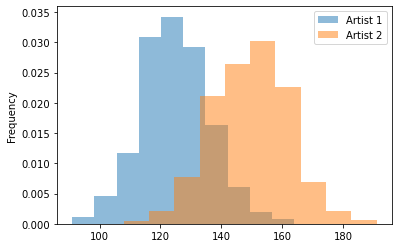

In [28]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: That regular expression matches the string with one or more whitespace.


In [29]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

In [30]:
# Your lyric length comparison chart here. 
new_dualipa = pd.DataFrame()

# Repeat "dualipa" 20 times and assign it to a new column
new_dualipa['Artist'] = pd.Series(['dualipa'] * 20)

# tokzenizing the lyrics and storing it
new_dualipa['Tokenized'] = dualipa_lyrics_df['File Content'].apply(tokenize_lyrics)

# count the lyrics and store it
new_dualipa['Tokenized Count'] = new_dualipa['Tokenized'].apply(len)

# new df for hozier
new_hozier = pd.DataFrame()

# Repeat "dualipa" 20 times and assign it to a new column
new_hozier['Artist'] = pd.Series(['hozier'] * 20)

# tokzenizing the lyrics and storing it
new_hozier['Tokenized'] = hozier_lyrics_df['File Content'].apply(tokenize_lyrics)

# count the lyrics and store it
new_hozier['Tokenized Count'] = new_hozier['Tokenized'].apply(len)

In [31]:
combined_df = pd.concat([new_dualipa,new_hozier], ignore_index = True)
combined_df = combined_df.rename(columns = {'Tokenized Count':'Length'})

Text(0.5, 1.0, 'Histogram of song lengths by artist')

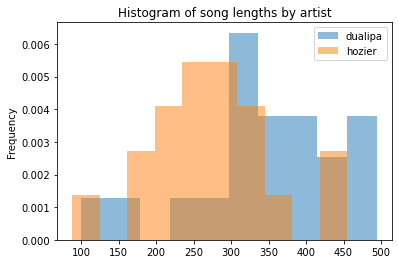

In [32]:
combined_df.groupby('Artist')['Length'].plot(kind="hist",density=True,alpha=0.5,legend=True)
plt.title('Histogram of song lengths by artist')